

- **Daily and Seasonal Consumption Patterns:**
   - Identify daily and seasonal consumption patterns to understand when electricity usage is highest and lowest. This can inform decisions on optimizing energy supply and demand.

- **Peak Load Analysis:**
   - Determine the peak electricity load periods, which can help utilities prepare for high-demand periods and avoid overloading the grid.

- **Time-of-Use Analysis:**
   - Analyze electricity usage during different times of the day to encourage consumers to shift their energy-intensive activities to off-peak hours when electricity is cheaper.

- **Load Profiling:**
   - Create load profiles for different customer segments (e.g., residential, commercial, industrial) to tailor energy management strategies.

   

- **Demand Forecasting:**
   - Use historical data to forecast future electricity demand, helping utilities plan for capacity expansion or reduction.

- **Customer Behavior Analysis:**
   - Understand how different customer groups use electricity and develop targeted strategies to encourage conservation or reduce waste.



In [1]:
# imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import datetime
import seaborn as sns

In [2]:
# Dataset : https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london

In [41]:
household_data = pd.read_csv("./dataset/informations_households.csv", encoding="utf-8")
print(f"There are {household_data['LCLid'].nunique()} households in information_households.csv")
print("Sample:")
household_data.head(3)

There are 5566 households in information_households.csv
Sample:


,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0


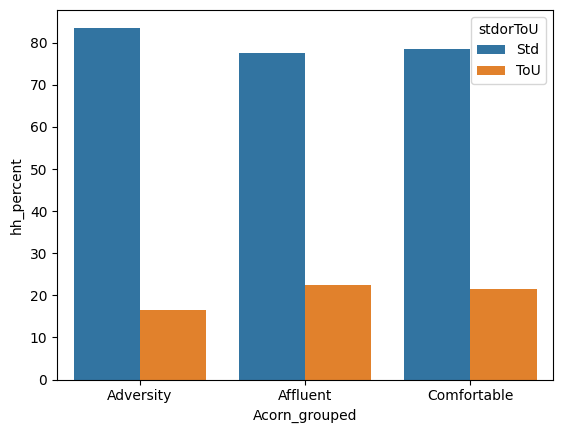

In [4]:
# Breakdown of Tariff based on Affluency

affluency_df = household_data[household_data["Acorn_grouped"].isin(["Adversity", "Affluent", "Comfortable"])][["Acorn_grouped", "stdorToU", "LCLid"]]
affluency_count = affluency_df.groupby(["Acorn_grouped"]).count().reset_index()
affluency_grouped = affluency_df.groupby(["Acorn_grouped", "stdorToU"]).count().reset_index()
affluency_grouped["hh_count"] = affluency_grouped["Acorn_grouped"].apply(lambda a: affluency_grouped[affluency_grouped["Acorn_grouped"] == a]["LCLid"].sum())
affluency_grouped["hh_percent"] = affluency_grouped["LCLid"] / affluency_grouped["hh_count"] * 100

sns.barplot(x="Acorn_grouped", y="hh_percent", hue="stdorToU", data=affluency_grouped)


In [5]:
acorn_data = pd.read_csv("./dataset/acorn_details.csv", encoding="ISO-8859-1")

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,119.0,67.0,114.0,113.0,89.0,123.0,138.0,133.0
1,POPULATION,Age,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,95.0,64.0,108.0,116.0,86.0,89.0,136.0,106.0
2,POPULATION,Age,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,104.0,459.0,97.0,96.0,86.0,117.0,109.0,110.0
3,POPULATION,Age,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,132.0,145.0,109.0,96.0,90.0,140.0,120.0,120.0
4,POPULATION,Age,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,111.0,67.0,99.0,98.0,90.0,102.0,103.0,100.0


In [67]:
# Get and clean data from block files

hh_block_path = Path("./dataset/halfhourly_dataset/halfhourly_dataset/")

def get_data_from_block_files(filepath, file_count = 5):
    # Get a random set of files and concatenate

    block_list = list(filepath.glob("*.csv"))
    file_list = random.choice(block_list, file_count, replace=False)
    final_df = pd.DataFrame()
    for file in file_list:
        # read file and filter only 2013 data
        file_name = str(file).split("\\")[-1]
        print(f"getting data from file: {file_name}")
        df = pd.read_csv(file, parse_dates=["tstp"])
        year_2013_mask = (df["tstp"] >= "2013-1-1") & (df["tstp"] <= "2013-12-31")
        final_df = pd.concat([final_df, df[year_2013_mask]])
        final_df.dropna(how="any", inplace=True)


    return final_df.reset_index(drop=True)

block_data = get_data_from_block_files(hh_block_path)
        

getting data from file: block_57.csv
getting data from file: block_99.csv
getting data from file: block_41.csv
getting data from file: block_56.csv
getting data from file: block_90.csv


In [68]:
# clean up 
block_data.rename(columns={"tstp":"datetime", "energy(kWh/hh)":"kWh"}, inplace=True)
block_data.drop(block_data[block_data["kWh"].isin(["Null"])].index, inplace=True)

print(f"Dataset has {block_data.shape[0]} rows from {block_data.drop_duplicates(subset=['LCLid']).shape[0]} households.")

Dataset has 4183019 rows from 249 households.


In [69]:

block_data["kWh"] = pd.to_numeric(block_data["kWh"])
block_data["quarter"] = block_data["datetime"].dt.quarter
block_data["date"] = block_data["datetime"].dt.date
block_data["month"] = block_data["datetime"].dt.month
block_data["time"] = block_data["datetime"].apply(lambda a: a.strftime("%I:%M %p"))

# pivot the data
# df_pivoted = block_data.pivot_table(index = ["LCLid", "date"], columns=["time"], values=["kWh"], sort=False).reset_index()

In [70]:
# merge the household, acorn and power data
merged_df = block_data.merge(household_data[["LCLid", "Acorn", "Acorn_grouped", "stdorToU"]], how="left", left_on="LCLid", right_on="LCLid", copy=False)

<Axes: xlabel='time'>

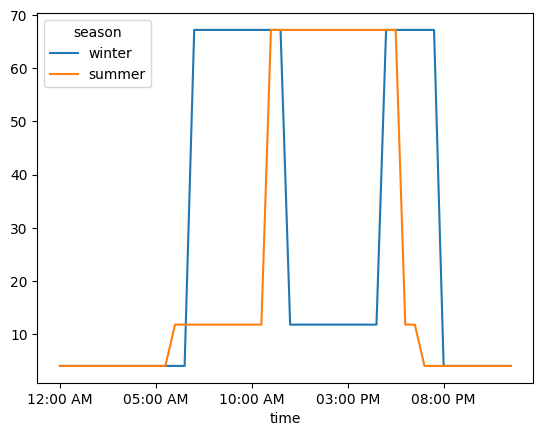

In [61]:
# Tou rates
tou_rate_grouped = merged_df[merged_df["stdorToU"] == "ToU"].pivot_table(index="time", columns="season", values="rate", aggfunc=np.median, sort=False)
tou_rate_grouped.plot()


In [60]:
# Assign rates
peak_rate = 67.20
off_peak_rate = 3.99
mid_peak_rate = 11.76
std_rate = 14.23

def get_tou_tariff(date):
    # https://www.londonhydro.com/accounts-services/electricity-rates

    month = date.month
    hour = date.hour

    if month >= 5 and month <= 10:
        #peak
        if (hour >= 11 and hour <= 17):
            return  peak_rate
        # off peak
        elif (hour > 17 and hour < 19) or (hour > 5 and hour < 11):
            return mid_peak_rate
        else: 
            return off_peak_rate
    else:
        #peak
        if (hour >= 7 and hour <= 11) or (hour >= 17 and hour <= 19):
            return peak_rate
        #off peak
        elif hour > 11 and hour < 17:
            return mid_peak_rate
        #mid peak
        else: 
            return  off_peak_rate
        
merged_df["rate"] = np.nan
merged_df.loc[merged_df[merged_df["stdorToU"] == "Std"].index,"rate"] = std_rate
merged_df.loc[merged_df["rate"].isna(),"rate"] = merged_df.loc[merged_df["rate"].isna(), "datetime"].apply(lambda date: get_tou_tariff(date))
merged_df["cost"] = merged_df["rate"] * merged_df["kWh"] / 100

# assign season
season_mask = (merged_df["datetime"].dt.month >= 5) & (merged_df["datetime"].dt.month <= 10)
merged_df["season"] = "winter"
merged_df.loc[season_mask, "season"] = "summer"


<Axes: xlabel='time'>

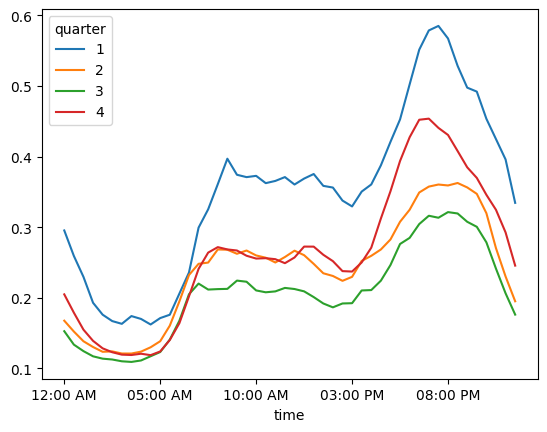

In [62]:
# Quarter energy usage by half hour readings

quarter_groupby = merged_df.pivot_table(index=["time"], columns="quarter", values="kWh", aggfunc=np.median, sort=False)
quarter_groupby.plot()


In [72]:
# Data stats

display(merged_df.drop_duplicates(subset=["LCLid"]).groupby(["Acorn", "Acorn_grouped", "stdorToU"]).count()["LCLid"])

Acorn    Acorn_grouped  stdorToU
ACORN-E  Affluent       Std         24
                        ToU         25
ACORN-F  Comfortable    Std         64
                        ToU         14
ACORN-G  Comfortable    Std         18
                        ToU          4
ACORN-O  Adversity      Std         44
                        ToU          6
ACORN-Q  Adversity      Std         50
Name: LCLid, dtype: int64

In [77]:
# Separate each Acorn group

acorn_groups = merged_df["Acorn"].unique().tolist()
acorn_groups_dict = {}
for group in acorn_groups:
    acorn_groups_dict[group] = merged_df[merged_df["Acorn"] == group].reset_index(drop=True)

<Axes: xlabel='time'>

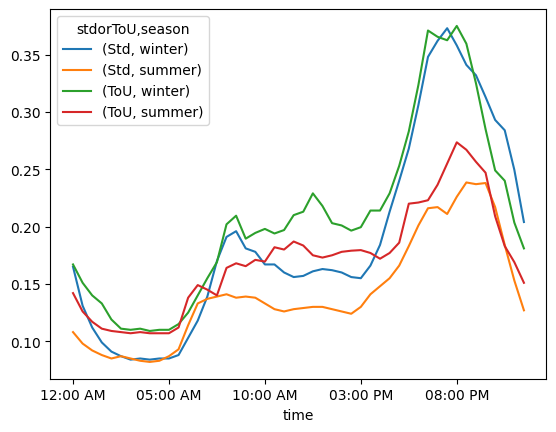

In [63]:
# Seasonal energy usage by tariff

seasonal_energy_usage = merged_df.pivot_table(index="time", columns=["stdorToU", "season"], values="kWh", aggfunc=np.median, sort=False)
seasonal_energy_usage.plot()

<Axes: xlabel='month'>

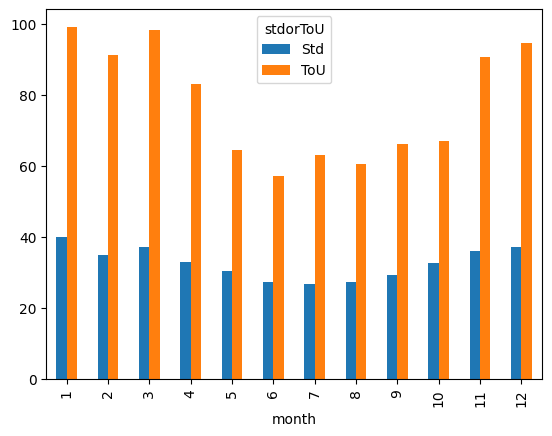

In [16]:
# Monthly cost ToU vs Std rate

total_energy_cost = merged_df.pivot_table(index=["month", "LCLid"], columns = ["stdorToU"], values = "cost", aggfunc=np.sum).reset_index()
per_house_energy_cost = total_energy_cost.drop(columns=["LCLid"]).groupby("month").median()[["Std", "ToU"]]
per_house_energy_cost.plot(kind="bar")

<Axes: xlabel='time'>

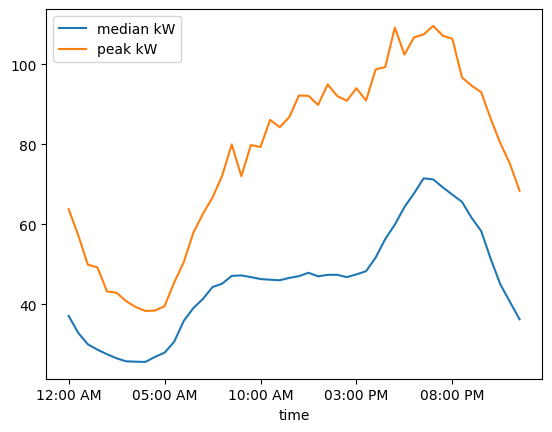

In [26]:
# Peak Load Analysis Total 
load_grouped = merged_df.pivot_table(index = "date", columns="time", values="kWh", aggfunc=np.sum, sort=False).dropna()
load_max = load_grouped.max()
load_median = load_grouped.median()
load_profile = pd.concat([load_median, load_max], axis=1)
load_profile.columns = ["median kW", "peak kW"]
load_profile.plot()

<Axes: xlabel='time'>

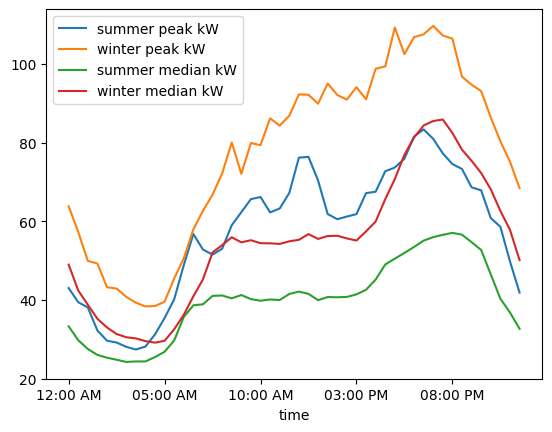

In [30]:
# Peak Load Analysis Season 
load_grouped_season = merged_df.pivot_table(index="date", columns=["season", "time"], values="kWh", aggfunc=np.sum, sort=False)
load_median_winter = load_grouped_season["winter"].median()
load_max_winter = load_grouped_season["winter"].max()
load_median_summer = load_grouped_season["summer"].median()
load_max_summer = load_grouped_season["summer"].max()
load_profile_season = pd.concat([load_max_summer, load_max_winter, load_median_summer, load_median_winter], axis=1)
load_profile_season.columns=["summer peak kW", "winter peak kW", "summer median kW", "winter median kW"]
load_profile_season.plot()